# How Representative is an Abortion Discussion on Twitter?

- [Eduardo Graells-Garrido](https://twitter.com/carnby), Data Science Institute, Universidad del Desarrollo
- [Ricardo Baeza-Yates](http://baeza.cl/), NTENT & Northeastern University
- [Mounia Lalmas](https://mounia-lalmas.blog/), Spotify

This notebook contains part of the analysis made in our [ACM Web Science'19](https://websci19.webscience.org/) poster. Particularly:

1. It describes the data released with the poster:
2. It shows how to fit the models of stance and demographic factors.

### Preamble

In [1]:
import pandas as pd
import numpy as np
import json
import pyreadstat
from statsmodels.formula.api import logit, glm
from statsmodels.api import families
from scipy.sparse import load_npz

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='ticks', font='Fira Sans', palette='viridis', font_scale=0.9,
       rc={'mathtext.default': 'regular'})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Data Set

#### 1. User Features

This file contains the following features:

- `index`: the user ID.
- `age_group`: the reported/inferred age group (see the `source` column).
- `gender`: the reported/inferred binary gender (see the `gender_source` column).
- `defense`, `opposition`: the user-stance weight given by the SeededLDA model.
- `stance`: the inferred user stance after calibrating the SeededLDA weights.

SeededLDA can be found in [this repository](https://github.com/vi3k6i5/GuidedLDA). It's a partial implementation of the GuidedLDA model, a semi-supervised variation of LDA.

In [2]:
user_features = pd.read_json('user_features.json.gz', lines=True).set_index('index')
user_features.sample(5)

,age_group,defense,followers,friends,gender,gender_source,opposition,source,stance
index,,,,,,,,,
117955785,18-24,0.999232,220,396,male,self-reported,0.000768,linearsvc,defense
26415239,18-24,0.999093,310,486,male,self-reported,0.000907,linearsvc,defense
69362892,25-34,0.171039,3055,4993,male,self-reported,0.828961,linearsvc,opposition
38862367,25-34,0.999643,539,1213,female,self-reported,0.000357,linearsvc,defense
494112233,35-44,0.000083,143,218,female,self-reported,0.999917,linearsvc,opposition


#### 2. User-Term Matrix and Vocabulary

This is a sparse matrix with the vocabulary associated to each user. 

- Rows are users. The corresponding ID for each row is on the `user_matrix_ids.json` file.
- Columns are terms from the vocabulary. The corresponding term for each column is on the `vocabulary_ids.json` file.

This matrix was used to fit the SeededLDA model, and to infer gender (see the paper for details).

In [3]:
user_matrix = load_npz('user_matrix.csr.npz')
repr(user_matrix)

"<104938x20188 sparse matrix of type '<class 'numpy.int64'>'\n\twith 8179507 stored elements in Compressed Sparse Row format>"

In [4]:
with open('user_matrix_ids.json') as f:
    user_matrix_ids = json.load(f)

In [5]:
len(user_matrix_ids)

104938

In [6]:
user_matrix_ids[0:5]

[818587115277590529, 128223099, 66496659, 181798099, 752661653364281344]

In [7]:
with open('vocabulary_ids.json') as f:
    vocabulary_ids = json.load(f)

In [8]:
len(vocabulary_ids)

20188

In [9]:
list(vocabulary_ids.items())[0:10]

[('"‘', 0),
 ('##dcsalvaachile', 1),
 ('#1', 2),
 ('#10deabril', 3),
 ('#10dejunio', 4),
 ('#10demarzo', 5),
 ('#10demayo', 6),
 ('#11deseptiembre', 7),
 ('#12diaschv', 8),
 ('#21m', 9)]

#### 3. Vocabulary

This is a dictionary with term frequencies. This is not used directly in the poster, but it is made available for exploratory purposes.

In [10]:
with open('vocabulary_frequency.json') as f:
    vocabulary = json.load(f)

In [11]:
len(vocabulary)

20188

In [12]:
print(sorted(vocabulary.items(), key=lambda x: x[1], reverse=True)[0:30])

[('aborto', 893176), ('ley', 163673), ('chile', 151912), ('#aborto3causales', 140150), ('causales', 131875), ('mujeres', 130773), ('proyecto', 119002), ('vida', 89428), ('mujer', 81404), ('ser', 65276), ('hoy', 61300), ('despenalizacion', 60223), ('tres', 56837), ('#aborto', 54545), ('provida', 53674), ('ahora', 48989), ('violacion', 45714), ('abortar', 42353), ('dc', 40351), ('@mileschile', 36375), ('senado', 34655), ('pinera', 34633), ('derechos', 34236), ('ninos', 33846), ('udi', 33129), ('gobierno', 33084), ('favor', 32812), ('todos', 32767), ('pais', 31698), ('anos', 31385)]


#### 4. Term-Stance Association

This is the term-stace values estimated with the SeededLDA model as described on the poster. This is not used directly in the poster, but it is made available for exploratory purposes.

In [13]:
term_topic = pd.read_json('lda_term_topic_matrix.json.gz', lines=True).set_index('index')
term_topic.sample(5)

,defense,opposition
index,,
siniestro,6.295800e-06,3.818880e-05
carretas,1.100000e-09,2.633080e-05
recibiera,1.100000e-09,1.447280e-05
@pamelagallegosm,4.749700e-06,3.619700e-06
who.int,1.126520e-05,2.000000e-09


In [14]:
term_topic.sort_values('defense', ascending=False).head(50).index

Index(['aborto', '#aborto3causales', 'causales', 'mujeres', 'ley', 'proyecto',
       'chile', 'mujer', 'despenalizacion', 'tres', 'provida', 'hoy', 'ser',
       'ahora', 'abortar', 'violacion', '@mileschile', 'udi', 'vida',
       'derechos', 'senado', 'pinera', 'derecha', '#aborto', 'anos',
       'terapeutico', 'aprueba', 'dc', 'embarazo', 'favor', '#apoyo3causales',
       'pais', 'causal', 'derecho', 'tc', 'debate', '#3causales', 'dia',
       'matrimonio', 'legal', 'salud', 'todos', 'uc', 'decidir', 'igualitario',
       'gobierno', 'discusion', 'abortos', 'aborto libre', 'aprobacion'],
      dtype='object', name='index')

In [15]:
term_topic.sort_values('opposition', ascending=False).head(50).index

Index(['aborto', 'chile', 'ley', 'vida', '#aborto', 'ser', 'mujer', 'proyecto',
       'ninos', 'muerte', 'hoy', 'dc', 'no al aborto', '@carolinagoic',
       '#noalaborto', 'gobierno', 'todos', 'mujeres', 'provida',
       'aborto libre', 'pl', 'causales', 'salud', '@joseantoniokast', 'madre',
       'bachelet', 'ahora', 'violacion', '@mbachelet', 'quiere', 'voto',
       'a favor del aborto', 'hijo', 'negocio', 'pro aborto', 'favor',
       '@soledadalvear', 'asesinato', 'matar', 'derecho', 'pais', '#sialavida',
       '#nolosdejaremossolos', 'crimen', 'humano', 'eldemocrata.cl', 'nino',
       'bien', 'nacer', 'siempre'],
      dtype='object', name='index')

#### 5. Population Weights

This is the total population in Chile according to the Census 2017. It is already aggregated for our purposes.

In [16]:
census = pd.read_csv('census_2017_population.csv', index_col=0)
census

,age_group,female,male,n,percent,source
0,< 18,586351,612585,1198936,8.296176,Census
1,18-24,1080223,1110332,2190555,15.157797,Census
2,25-34,1368036,1370769,2738805,18.951476,Census
3,35-44,1213329,1167631,2380960,16.475327,Census
4,45-54,1207996,1123688,2331684,16.134356,Census
5,>= 55,1973503,1637228,3610731,24.984869,Census


In [17]:
census['female_weight'] = census['female'] / census['n'].sum()
census['male_weight'] = census['male'] / census['n'].sum()

In [18]:
census_weights = census[['age_group', 'female_weight', 'male_weight']]
census_weights.columns = ['age_group', 'female', 'male']
census_weights

,age_group,female,male
0,< 18,0.040573,0.042389
1,18-24,0.074747,0.076831
2,25-34,0.094663,0.094852
3,35-44,0.083958,0.080796
4,45-54,0.083589,0.077755
5,>= 55,0.136559,0.113290


In [19]:
census_weights = (pd.melt(census_weights, id_vars=['age_group'], value_vars=['female', 'male'])
                  .rename(columns={'variable': 'gender', 'value': 'weight'}))
census_weights

,age_group,gender,weight
0,< 18,female,0.040573
1,18-24,female,0.074747
2,25-34,female,0.094663
3,35-44,female,0.083958
4,45-54,female,0.083589
5,>= 55,female,0.136559
6,< 18,male,0.042389
7,18-24,male,0.076831
8,25-34,male,0.094852
9,35-44,male,0.080796


In [20]:
weighted_users = (user_features[user_features.gender != 'n/a']
                  [['followers', 'friends', 'stance', 'age_group', 'gender']]
                  .assign(in_defense=lambda x: (x['stance'] == 'defense').astype(np.int))
                  .merge(census_weights, how='inner')
                  .assign(weight=lambda x: x['weight'] / x['weight'].sum() * len(x))
)
weighted_users.sample(10)

,followers,friends,stance,age_group,gender,in_defense,weight
33080,803,742,defense,18-24,male,1,0.962417
6207,117,66,opposition,18-24,female,0,0.936319
50845,271,283,defense,18-24,male,1,0.962417
16228,202,817,defense,18-24,female,1,0.936319
79962,110,162,defense,25-34,female,1,1.185791
11371,515,396,defense,18-24,female,1,0.936319
33664,8544,4404,defense,18-24,male,1,0.962417
68011,390,884,defense,25-34,male,1,1.188160
87574,111,166,defense,35-44,male,1,1.012083
84511,89,390,opposition,>= 55,male,0,1.419122


#### 6. CEP

The Centro de Estudios Públicos (CEP) Survey contains nationally-representative opinions about several issues in Chile. This one in particular, from 2017, contains opinions about abortion.

In [21]:
cep, cep_meta = pyreadstat.read_sav('Encuesta CEP 79 Abr-May 2017 v1.sav', apply_value_formats=True)

## Stance and Demographic Factors

Having all these data sets, then we can train a model to see how demographic factors of age and binary gender are related to the stance with respect to abortion. We fit three logistic models:

1. One with non-weighted Twitter profiles.
2. One with census-weighted Twitter profiles.
3. One with a 

#### Non-Weighted Model - Twitter

In [22]:
model_simple = logit('in_defense ~ C(age_group, Treatment(\'18-24\')) + C(gender, Treatment(\'female\'))', 
              data=weighted_users)
results_simple = model_simple.fit()
results_simple.summary()

Optimization terminated successfully.
         Current function value: 0.566044
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             in_defense   No. Observations:                93608
Model:                          Logit   Df Residuals:                    93601
Method:                           MLE   Df Model:                            6
Date:                Fri, 28 Jun 2019   Pseudo R-squ.:                0.007661
Time:                        23:38:33   Log-Likelihood:                -52986.
converged:                       True   LL-Null:                       -53395.
                                        LLR p-value:                1.856e-173
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     1.3336      0.013    101.531      0.000       1.308       1.359
C(age_group, Treatment('18-24'))[T.25-34]    -0.1763      0.020     -8.598      0.000      -0.216      -0.136
C(age_group, Treatment('18-24'))[T.35-44]    -0.2644      0.024    -10.913      0.000      -0.312      -0.217
C(age_group, Treatment('18-24'))[T.45-54]    -0.4115      0.029    -14.245      0.000      -0.468      -0.355
C(age_group, Treatment('18-24'))[T.< 18]     -0.2294      0.039     -5.850      0.000      -0.306      -0.153
C(age_group, Treatment('18-24'))[T.>= 55]    -0.4948      0.044    -11.327      0.000      -0.580      -0.409
C(gender, Treatment('female'))[T.male]       -0.2812      0.015    -18.235      0.000      -0.311      -0.251
=============================================================================================================
"""

#### Weighted Model - Twitter

In [23]:
model_weighted = glm('in_defense ~ C(age_group, Treatment(\'18-24\')) + C(gender, Treatment(\'female\'))', 
            weighted_users, 
            freq_weights=weighted_users['weight'], 
            family=families.Binomial(families.links.logit))
results_weighted = model_weighted.fit()
results_weighted.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Generalized linear model
==========================================================================================
Model:                       GLM                      AIC:                    106373.7073 
Link Function:               logit                    BIC:                    -965078.8772
Dependent Variable:          in_defense               Log-Likelihood:         -53180.     
Date:                        2019-06-28 23:38         LL-Null:                -53600.     
No. Observations:            93608                    Deviance:               1.0636e+05  
Df Model:                    6                        Pearson chi2:           9.36e+04    
Df Residuals:                93601                    Scale:                  1.0000      
Method:                      IRLS                                                         
------------------------------------------------------------------------------------------
                                           Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------------
Intercept                                  1.3346   0.0134  99.6559 0.0000  1.3084  1.3609
C(age_group, Treatment('18-24'))[T.25-34] -0.1760   0.0194  -9.0873 0.0000 -0.2140 -0.1381
C(age_group, Treatment('18-24'))[T.35-44] -0.2637   0.0241 -10.9555 0.0000 -0.3109 -0.2166
C(age_group, Treatment('18-24'))[T.45-54] -0.4117   0.0290 -14.1937 0.0000 -0.4685 -0.3548
C(age_group, Treatment('18-24'))[T.< 18]  -0.2297   0.0536  -4.2846 0.0000 -0.3348 -0.1246
C(age_group, Treatment('18-24'))[T.>= 55] -0.4838   0.0363 -13.3444 0.0000 -0.5549 -0.4128
C(gender, Treatment('female'))[T.male]    -0.2831   0.0154 -18.3946 0.0000 -0.3133 -0.2530
==========================================================================================

"""

#### Weighted Model - CEP survey

In [25]:
stance_proportions = cep.groupby(['ACTI_8'])['pond'].sum()#.unstack()
stance_proportions /= stance_proportions.sum()
stance_proportions

ACTI_8
1.- El aborto debe estar siempre prohibido                              0.269707
2.- El aborto sólo debe estar permitido en casos especiales             0.493850
3.- El aborto debe ser una opción para las mujeres en cualquier caso    0.206481
8. No sabe                                                              0.018010
9. No contesta                                                          0.011952
Name: pond, dtype: float64

In [26]:
cep_gender_proportions = cep.groupby(['ACTI_8', 'Sexo'])['pond'].sum().unstack()
cep_gender_proportions.div(cep_gender_proportions.sum(axis=1), axis=0)

Sexo,Hombre,Mujer
ACTI_8,,
1.- El aborto debe estar siempre prohibido,0.531018,0.468982
2.- El aborto sólo debe estar permitido en casos especiales,0.472209,0.527791
3.- El aborto debe ser una opción para las mujeres en cualquier caso,0.479115,0.520885
8. No sabe,0.491055,0.508945
9. No contesta,0.415474,0.584526


For simplicity purposes, we assumed that "doesn't known/doesn't answer" tends to be in defense of abortion rights:

In [27]:
cep['in_defense'] = (~cep.ACTI_8.isin(['1.- El aborto debe estar siempre prohibido', '8. No sabe', '9. No contesta'])).astype(np.int)

In [28]:
cep.rename(columns={'Sexo': 'gender', 'Edad_rec': 'age_group'}, inplace=True)

In [29]:
cep.age_group.replace(' a ', '-', regex=True, inplace=True)
cep.age_group.replace('55 años o más', '>= 55', inplace=True)
cep.age_group.replace(' años', '', regex=True, inplace=True)
cep.gender.replace('Mujer', 'female', inplace=True)
cep.gender.replace('Hombre', 'male', inplace=True)

In [30]:
model_cep = glm('in_defense ~ C(gender, Treatment(\'female\')) + C(age_group, Treatment(\'18-24\'))', 
            cep, 
            freq_weights=cep['pond'], 
            family=families.Binomial(families.links.logit))
results_cep = model_cep.fit()
results_cep.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Generalized linear model
=========================================================================================
Model:                        GLM                      AIC:                    1801.2536 
Link Function:                logit                    BIC:                    -8978.9438
Dependent Variable:           in_defense               Log-Likelihood:         -894.63   
Date:                         2019-06-28 23:38         LL-Null:                -904.27   
No. Observations:             1481                     Deviance:               1789.3    
Df Model:                     5                        Pearson chi2:           1.48e+03  
Df Residuals:                 1475                     Scale:                  1.0000    
Method:                       IRLS                                                       
-----------------------------------------------------------------------------------------
                                           Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------
Intercept                                  1.2959   0.1754  7.3881 0.0000  0.9521  1.6396
C(gender, Treatment('female'))[T.male]    -0.2170   0.1143 -1.8981 0.0577 -0.4411  0.0071
C(age_group, Treatment('18-24'))[T.25-34] -0.0635   0.2110 -0.3011 0.7633 -0.4771  0.3500
C(age_group, Treatment('18-24'))[T.35-44] -0.3064   0.2113 -1.4499 0.1471 -0.7206  0.1078
C(age_group, Treatment('18-24'))[T.45-54] -0.5043   0.2089 -2.4147 0.0157 -0.9137 -0.0950
C(age_group, Treatment('18-24'))[T.>= 55] -0.5820   0.1934 -3.0101 0.0026 -0.9610 -0.2030
=========================================================================================

"""

### Comparing Models

In [31]:
result_comparison = (pd.DataFrame({'CEP Survey': results_cep.params})
 .join(pd.Series(results_weighted.params, name='Twitter (Weighted)'), how='right')
 .join(pd.Series(results_simple.params, name='Twitter (Simple)'), how='right')
)

In [32]:
result_comparison['factor'] = ['Baseline\n(Male, Age 18-24)', 'Age 25-34', 'Age 35-44', 'Age 45-54', 'Age < 18', 'Age >= 55', 'Female']
result_comparison.set_index('factor', inplace=True)

In [33]:
tabuled_results = result_comparison.loc[['Baseline\n(Male, Age 18-24)', 'Female', 'Age < 18', 'Age 25-34', 'Age 35-44', 'Age 45-54', 'Age >= 55']]

In [34]:
tabuled_results.unstack().reset_index()

,level_0,factor,0
0,CEP Survey,"Baseline\n(Male, Age 18-24)",1.295867
1,CEP Survey,Female,-0.216993
2,CEP Survey,Age < 18,NaN
3,CEP Survey,Age 25-34,-0.063531
4,CEP Survey,Age 35-44,-0.306396
5,CEP Survey,Age 45-54,-0.504313
6,CEP Survey,Age >= 55,-0.582023
7,Twitter (Weighted),"Baseline\n(Male, Age 18-24)",1.334628
8,Twitter (Weighted),Female,-0.283137
9,Twitter (Weighted),Age < 18,-0.229730


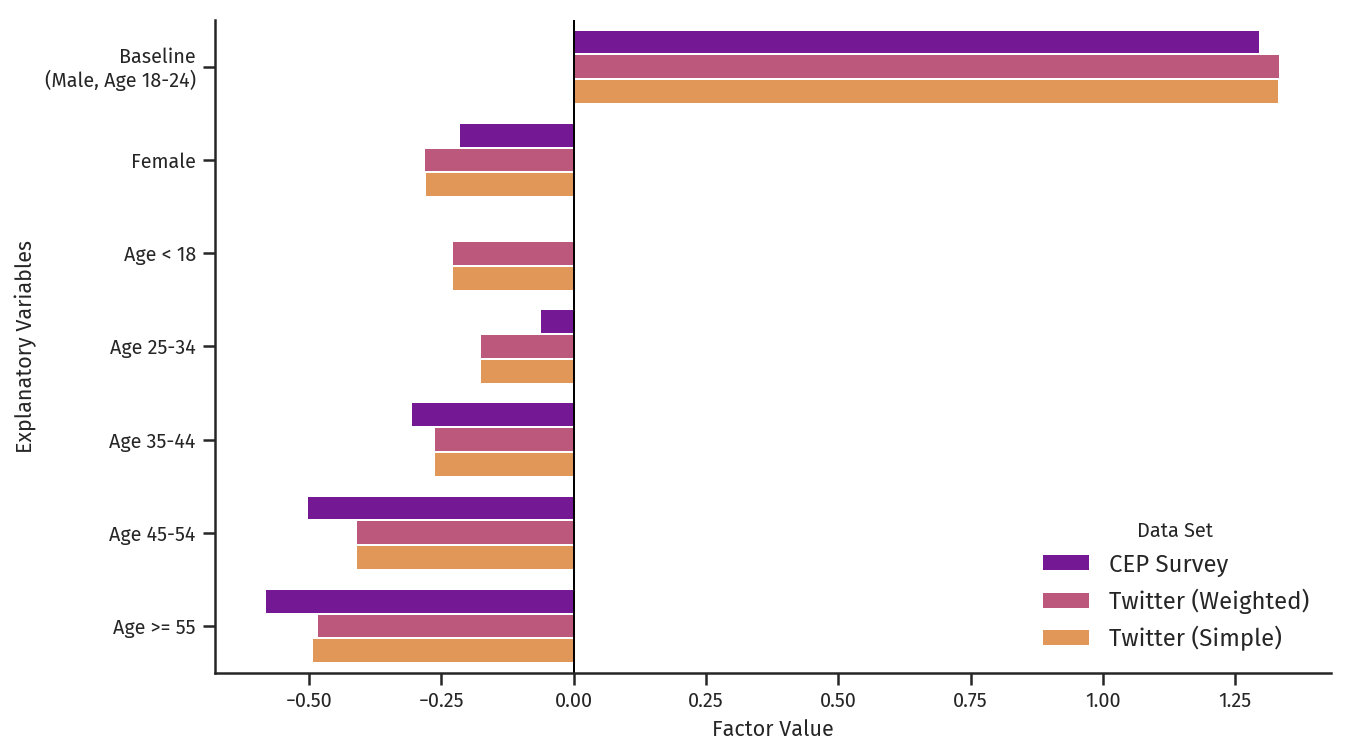

In [35]:
plt.figure(figsize=(10, 6))
sns.barplot(y='factor', x=0, hue='Data Source', data=tabuled_results.unstack().reset_index().rename(columns={'level_0': 'Data Source'}), 
            palette='plasma')
plt.xlabel('Factor Value')
plt.ylabel('Explanatory Variables')
plt.axvline(x=0, linewidth=1, color='black')
sns.despine()
plt.legend(frameon=False, title='Data Set', fontsize=12)

As seen on the figure, all factors have similar magnitudes and same signs in all models! Given that the Twitter population _is_ biased, one would expect otherwise. 

Have any questions about this work? Feel free to write us at egraells@udd.cl!